# Development Notebook for IFAT Simulator

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def visualize_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [3]:
MODE = 'adaptive'
PARASITICS = True

In [4]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [5]:
# IFAT specific definitions
fF = 0.001 * pF
Vdd = 5 * volt
Cm = Ct = 440 * fF
Cl = 2 * fF

W_vals  = np.array([5, 10, 20, 40, 80]) * fF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = True
par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

In [6]:
# Model parameters
Vm_r = 1.25 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 3 * volt
flt  = 0 * MHz
Cst  = 0 * fF

N = 4

In [7]:
start_scope()
defaultclock.dt = 0.2 * us

# Start stuff up
test = NeuronGroup(N, neuron_eq, threshold='Vm > Vt', reset=reset_eq, method='exact')
test.Vm = Vm_r
test.Vt = Vt_r

bg_rate = 6*kHz
bg_spk_times = np.arange(0,0.1,Hz/bg_rate) * second
bg_spk_inds  = np.zeros_like(bg_spk_times)
bg_spks = SpikeGeneratorGroup(1,bg_spk_inds,bg_spk_times)

bg_syn = Synapses(bg_spks, test, syn_eq, on_pre=presyn_eq)
bg_syn.connect()
bg_syn.delay = "j * 0.2 * us"
bg_syn.Em = Em_vals[2]
bg_syn.W  = W_vals[3] + W_vals[2] + W_vals[0]

exc_syn = Synapses(test, test, syn_eq, on_pre=presyn_eq)
exc_syn.connect('j==((i+1)%(4))')
exc_syn.Em = Em_vals[3]
exc_syn.W  = sum(W_vals[0:2])

inh_syn = Synapses(test, test, syn_eq, on_pre=presyn_eq)
inh_syn.connect('j==((i+2)%4)')
inh_syn.connect('j==((i+3)%4)')
inh_syn.Em = Em_vals[0]
inh_syn.W  = sum(W_vals)*2

sp_mon = SpikeMonitor(test)
vm_mon = StateMonitor(test, 'Vm', record=True, dt=0.1*ms)
vt_mon = StateMonitor(test, 'Vt', record=True, dt=0.1*ms)
ratemon = PopulationRateMonitor(test)

In [10]:
#visualize_connectivity(inh_syn)
#visualize_connectivity(exc_syn)

In [13]:
BrianLogger.suppress_hierarchy('brian2.codegen.generators.base')
run(100*ms,report='text')

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]


Starting simulation at t=0. s for a duration of 100. ms
0.0296948 (29%) simulated in 10s, estimated 24s remaining.
0.0582648 (58%) simulated in 20s, estimated 14s remaining.
0.0881454 (88%) simulated in 30s, estimated 4s remaining.
0.1 (100%) simulated in 33s


(0, 100)

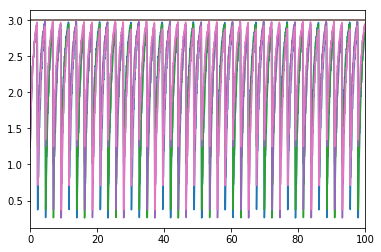

In [14]:
for i in range(N):
    plot(vm_mon.t/ms, vm_mon.Vm[i]/volt,vt_mon.t/ms, vt_mon.Vt[i]/volt)
xlim([0,100])

(0, 4)

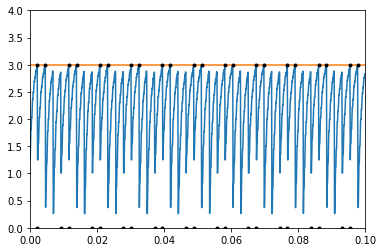

In [15]:
plot(vm_mon.t, vm_mon.Vm[1]/volt,vt_mon.t, vt_mon.Vt[0]/volt); xlim([0,0.1]);
plot(sp_mon.t, sp_mon.i*3,'.k')
ylim([0,4])

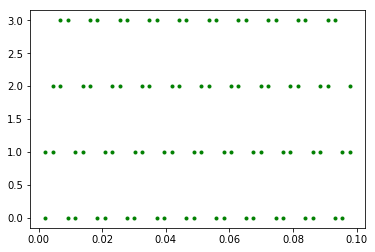

In [16]:
plot(sp_mon.t, sp_mon.i, '.g'); #xlim([0.062,0.082]);

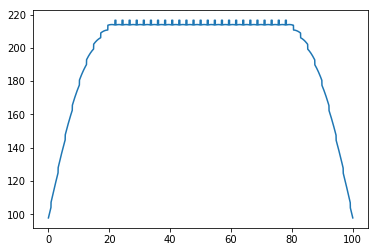

In [17]:
plot(ratemon.t/ms, ratemon.smooth_rate(width=10*ms)/Hz)

## Trying the *Other* Tad Blair approach

In [27]:
def calc_weight(M, alpha, mu, sigma):
    output = zeros((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            output[i,j] = exp(cos((2*pi*i/M) - (2*pi*j/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * fF * np.around(output/(5.0*fF))
    return output

In [28]:
Vm_r = 0.75 * volt
Vt_r = 3.5*volt
M = 64
alpha = sum(W_vals)
mu1 = 0
mu2 = 2*pi/3
mu3 = pi
sigma = 25 * pi/180
fF = 0.001 * pF

In [57]:
start_scope()
defaultclock.dt = 0.1*ms;

blair_exc = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
blair_inh = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')

blair_exc.Vt = Vt_r
blair_inh.Vt = Vt_r
blair_exc.Vm = Vm_r
blair_inh.Vm = Vm_r

exc2inh = Synapses(blair_exc, blair_inh, syn_eq, on_pre=presyn_eq)
exc2inh.connect()
exc2inh.Em = Em_vals[3]

exc2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

inh2exc = Synapses(blair_inh, blair_exc, syn_eq, on_pre=presyn_eq)
inh2exc.connect()
inh2exc.Em = Em_vals[0]
inh2exc.W  = calc_weight(M,alpha,mu2,sigma).flatten()

inh2inh = Synapses(blair_inh, blair_inh, syn_eq, on_pre=presyn_eq)
inh2inh.connect()
inh2inh.Em = Em_vals[0]
inh2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

PoisIn = PoissonGroup(M,rates=3*kHz)

p2exc = Synapses(PoisIn, blair_exc, syn_eq, on_pre=presyn_eq)
p2exc.connect('j==i')
p2exc.Em = Em_vals[3]
p2exc.W = (W_vals[2])

i_spmon = SpikeMonitor(blair_inh)
e_spmon = SpikeMonitor(blair_exc)
e_vmon = StateMonitor(blair_exc, 'Vm', record=True)
erate0 = PopulationRateMonitor(blair_exc[:1])
erate1 = PopulationRateMonitor(blair_exc[1:2])
erate10 = PopulationRateMonitor(blair_exc[10:11])
erate20 = PopulationRateMonitor(blair_exc[13:14])
irate = PopulationRateMonitor(blair_inh[:1])

In [66]:
run(10*second,report='text')

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block tha

Starting simulation at t=0. s for a duration of 10. s
7.3916 (73%) simulated in 10s, estimated 4s remaining.
10.0 (100%) simulated in 13s


Text(0,0.5,'Neuron index')

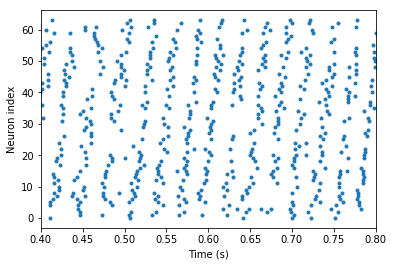

In [88]:
plot(e_spmon.t/second, e_spmon.i,'.'); xlim([0.4,0.8])
xlabel('Time (s)')
ylabel('Neuron index')

Text(0,0.5,'Membrane voltage (V)')

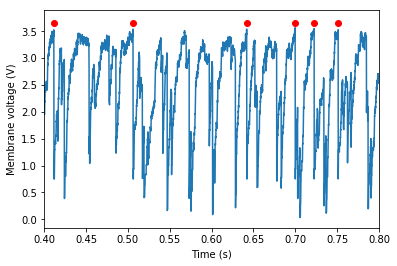

In [89]:
plot(e_vmon.t, e_vmon.Vm[0]); xlim([0.4,0.8])
scatter(e_spmon.t[e_spmon.i==0],3.65*ones(len(e_spmon.t[e_spmon.i==0])),color='r')
xlabel('Time (s)')
ylabel('Membrane voltage (V)')

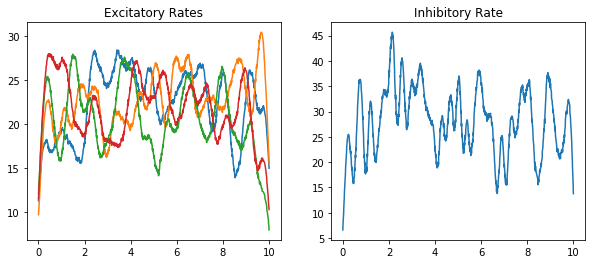

In [90]:
rateWidth = 200 * ms

figure(figsize=(10,4))
subplot(121)
plot(erate0.t/second,   erate0.smooth_rate(width=rateWidth),
     erate1.t/second,   erate1.smooth_rate(width=rateWidth),
     erate10.t/second, erate10.smooth_rate(width=rateWidth),
     erate20.t/second, erate20.smooth_rate(width=rateWidth))#,
title('Excitatory Rates');
subplot(122)
plot(irate.t/second,irate.smooth_rate(width=100*ms))
title('Inhibitory Rate');

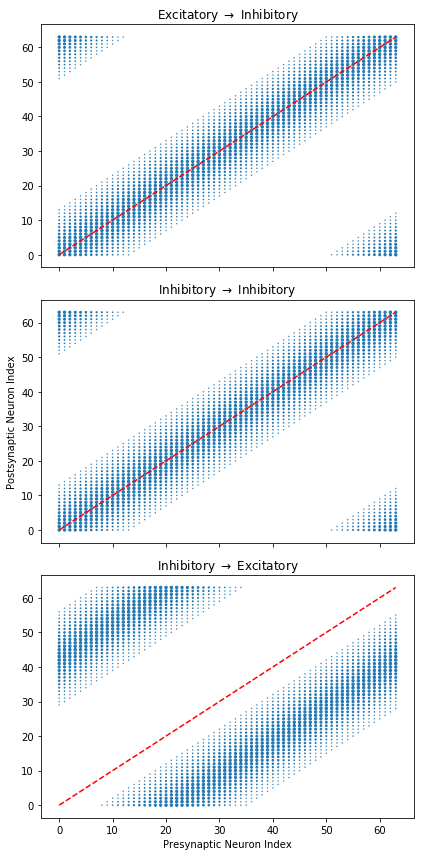

In [91]:
fig, axs = subplots(3,1,figsize=(6,12),sharex='all',sharey='all')
axs[0].scatter(exc2inh.i,exc2inh.j,s=exc2inh.W/(25*fF))
axs[0].plot(arange(M),arange(M),'--r')
axs[0].set_title(r'Excitatory $\rightarrow$ Inhibitory')
axs[1].set_ylabel(r'Postsynaptic Neuron Index')
axs[1].scatter(inh2inh.i,inh2inh.j,s=inh2inh.W/(25*fF))
axs[1].plot(arange(M),arange(M),'--r')
axs[1].set_title(r'Inhibitory $\rightarrow$ Inhibitory')
axs[2].set_xlabel(r'Presynaptic Neuron Index')
axs[2].scatter(inh2exc.i,inh2exc.j,s=inh2exc.W/(25*fF))
axs[2].plot(arange(M),arange(M),'--r')
axs[2].set_title(r'Inhibitory $\rightarrow$ Excitatory')
tight_layout()